In [1]:
# Imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from load_data import (
    get_without_time,
    used_resources,
    reserved_resources,
    lost_resources,
    lost_resources_by_label,
    stolen_resources,
    reserved_resources_by_label,
    used_resources_by_label,
)
from colors import colors_label, get_color, colors_palette
from constants import COMPUTING_RESOURCES, ARCHITECTURES
import squarify

/Users/thibaultsimon/Documents/projects/thesis/3_ecodesign/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/thibaultsimon/Documents/projects/thesis/3_ecodesign/load_data.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[label][result[label] < 0] = 0
/Users/thibaultsimon/Documents/projects/thesis/3_ecodesign/load_data.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[label][result[label] < 0] = 0

In [2]:
print(pd.DataFrame(used_resources["KVM"])["Time"].diff())
delta_timestamps_seconds = 30

0                  NaT
1      0 days 00:00:30
2      0 days 00:00:30
3      0 days 00:00:30
4      0 days 00:00:30
             ...      
1556   0 days 00:00:30
1557   0 days 00:00:30
1558   0 days 00:00:30
1559   0 days 00:00:30
1560   0 days 00:00:30
Name: Time, Length: 1561, dtype: timedelta64[ns]


# Functions


# Impact factors


In [3]:
f_cpu_die_gwp = 1.97
f_cpu_die_adp = 5.87e-07
f_cpu_die_pe = 2.65e01

i_cpu_base_gwp = 9.14
i_cpu_base_adp = 2.04e-02
i_cpu_base_pe = 156.43

f_flash_die_gwp = 2.20
f_flash_die_adp = 6.30e-05
f_flash_die_pe = 2.73e01

i_ram_base_gwp = 5.22
i_ram_base_adp = 1.69e-03
i_ram_base_pe = 74.00

i_ssd_base_gwp = 6.34
i_ssd_base_adp = 5.63e-04
i_ssd_base_pe = 73.98

i_hdd_gwp = 3.11e01
i_hdd_adp = 2.50e-04
i_hdd_pe = 2.76e02

f_psu_e_gwp = 2.43e01
f_psu_e_adp = 8.30e-03
f_psu_e_pe = 3.52e02

i_motherboard_gwp = 6.61e01
i_motherboard_adp = 3.69e-03
i_motherboard_pe = 8.36e02

i_assembly_gwp = 6.68
i_assembly_adp = 1.41e-06
i_assembly_pe = 6.86e01

i_rack_gwp = 1.50e02
i_rack_adp = 2.02e-02
i_rack_pe = 2.20e03

# Env


In [4]:
PUE = 1.5
EMB_DC = 2.61e-02 / 1000

## R740


## Embodied


In [5]:
life_expectency = 5 * 365 * 24

r740_vcpus = 44
r740_ram = 12 * 32
r740_storage = 400 + 8 * 3840

cpu_e_gwp = 45.6236  # See hotcarbon
ram_e_gwp = 534.5953072625698  # See hotcarbon
ssd_e_gwp = 3660.4284210526316  # See hotcarbon
others_gwp = 295.4856  # See hotcarbon

instance_vcpu = 4
instance_vram = 8
instance_vssd = 80


def vres_e(emb_impact: float, quantity: int, total_instance: int):
    return (emb_impact / life_expectency) * (quantity / total_instance)


ci_cpu_e = vres_e(cpu_e_gwp, instance_vcpu, r740_vcpus)
ci_ram_e = vres_e(ram_e_gwp, instance_vram, r740_ram)
ci_storage_e = vres_e(ssd_e_gwp, instance_vssd, r740_storage)


print(ci_cpu_e)
print(ci_ram_e)
print(ci_storage_e)

9.469406392694064e-05
0.000254278589831892
0.0002148365684786322


# Cloud instance


## Embodied


In [6]:
life_expectency = 5 * 365 * 24

r740_vcpus = 44
r740_ram = 12 * 32
r740_storage = 400 + 8 * 3840

instance_vcpu = 4
instance_vram = 8
instance_vssd = 80


def vres_e(emb_impact: float, quantity: int, total_instance: int):
    return (emb_impact / life_expectency) * (quantity / total_instance)


ci_cpu_e = vres_e(cpu_e_gwp, instance_vcpu, r740_vcpus)
ci_ram_e = vres_e(ram_e_gwp, instance_vram, r740_ram)
ci_storage_e = vres_e(ssd_e_gwp, instance_vssd, r740_storage)


print(ci_cpu_e)
print(ci_ram_e)
print(ci_storage_e)

9.469406392694064e-05
0.000254278589831892
0.0002148365684786322


## Usage


In [7]:
power_cpu = 104.75
power_ram = 0.54 * r740_ram
power_ssd = 5.7 * 9  # https://www.techpowerup.com/ssd-specs/samsung-950-pro-512-gb.d74

others_power = 0.2 * (power_cpu + power_ram + power_ssd)
total_power = power_cpu + power_ram + power_ssd + others_power

elec_mix = 0.098 / 1000


def vres_u(usage_impact: float, quantity: int, total_instance: int):
    # return usage_impact * (quantity / total_instance)
    return (usage_impact * quantity) / total_instance


ci_cpu_u = vres_u((power_cpu * elec_mix), instance_vcpu, r740_vcpus)
ci_ram_u = vres_u((power_ram * elec_mix), instance_vram, r740_ram)
ci_storage_u = vres_u((power_ssd * elec_mix), instance_vssd, r740_storage)

print(ci_cpu_u)
print(ci_ram_u)
print(ci_storage_u)

0.0009332272727272727
0.00042336000000000007
1.2923907455012858e-05


In [8]:
# On ne compte pas les disques, que cpu ram others environment
#


def get_instance_gwp_u(
    instance_cpu: float, instance_memory: float, duration_seconds: float
) -> float:
    cpu = vres_u((power_cpu * elec_mix), instance_cpu, r740_vcpus)
    ram = vres_u((power_ram * elec_mix), instance_memory, r740_ram)
    others = vres_u((others_power * elec_mix), instance_vcpu, r740_vcpus)

    # Assess total instance cons for env
    cpu_cons = power_cpu * (instance_cpu / r740_vcpus)
    ram_cons = power_ram * (instance_memory / r740_ram)
    # i_ssd_cons = power_ssd * (instance_vssd / r740_storage)
    others_cons = others_power * (instance_cpu / r740_vcpus)
    power = cpu_cons + ram_cons + others_cons
    environment = (power) * (PUE - 1) * elec_mix

    return (cpu + ram + others + environment) * (duration_seconds / 3600)


def get_instance_gwp_e(
    instance_cpu: float, instance_memory: float, duration_seconds: float
) -> float:
    cpu = vres_e(cpu_e_gwp, instance_cpu, r740_vcpus)
    ram = vres_e(ram_e_gwp, instance_memory, r740_ram)
    others = vres_e(others_gwp, instance_vcpu, r740_vcpus)

    # Assess total instance cons for env
    cpu_cons = power_cpu * (instance_cpu / r740_vcpus)
    ram_cons = power_ram * (instance_memory / r740_ram)
    # i_ssd_cons = power_ssd * (instance_vssd / r740_storage)
    others_cons = others_power * (instance_cpu / r740_vcpus)
    power = cpu_cons + ram_cons + others_cons
    environment = power * EMB_DC

    return (cpu + ram + others + environment) * (duration_seconds / 3600)


def get_instance_gwp(
    instance_cpu: float, instance_memory: float, duration_seconds: float
) -> float:
    usage = get_instance_gwp_u(instance_cpu, instance_memory, duration_seconds)
    embodied = get_instance_gwp_e(instance_cpu, instance_memory, duration_seconds)

    return usage + embodied

# Used


## Data


In [9]:
used_kvm = pd.DataFrame(used_resources["KVM"])
used_kvm["GWP"] = used_kvm.apply(
    lambda row: get_instance_gwp(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
used_kvm["Embodied"] = used_kvm.apply(
    lambda row: get_instance_gwp_e(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
used_kvm["Usage"] = used_kvm.apply(
    lambda row: get_instance_gwp_u(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
used_kvm

,Memory,CPU,Time,GWP,Embodied,Usage
0,14.217286,0.414257,2024-04-09 07:26:00,0.000027,0.000011,0.000016
1,14.246220,0.438000,2024-04-09 07:26:30,0.000027,0.000011,0.000016
2,14.246785,0.404800,2024-04-09 07:27:00,0.000027,0.000011,0.000016
3,14.290379,0.412400,2024-04-09 07:27:30,0.000027,0.000011,0.000016
4,14.314996,0.361200,2024-04-09 07:28:00,0.000027,0.000011,0.000016
...,...,...,...,...,...,...
1556,20.477383,0.480857,2024-04-09 20:24:00,0.000034,0.000013,0.000021
1557,20.430860,0.494800,2024-04-09 20:24:30,0.000034,0.000013,0.000021
1558,20.412129,0.467200,2024-04-09 20:25:00,0.000034,0.000013,0.000021
1559,20.375200,0.475600,2024-04-09 20:25:30,0.000034,0.000013,0.000021


In [10]:
reserved_kvm = pd.DataFrame(reserved_resources["KVM"])
reserved_kvm["GWP"] = reserved_kvm.apply(
    lambda row: get_instance_gwp(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
reserved_kvm["Embodied"] = reserved_kvm.apply(
    lambda row: get_instance_gwp_e(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
reserved_kvm["Usage"] = reserved_kvm.apply(
    lambda row: get_instance_gwp_u(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
reserved_kvm

,Memory,CPU,Time,GWP,Embodied,Usage
0,38.990381,24,2024-04-09 07:26:00,0.000163,0.000046,0.000117
1,38.990381,24,2024-04-09 07:26:30,0.000163,0.000046,0.000117
2,38.990381,24,2024-04-09 07:27:00,0.000163,0.000046,0.000117
3,38.990381,24,2024-04-09 07:27:30,0.000163,0.000046,0.000117
4,38.990381,24,2024-04-09 07:28:00,0.000163,0.000046,0.000117
...,...,...,...,...,...,...
1556,38.990381,24,2024-04-09 20:24:00,0.000163,0.000046,0.000117
1557,38.990381,24,2024-04-09 20:24:30,0.000163,0.000046,0.000117
1558,38.990381,24,2024-04-09 20:25:00,0.000163,0.000046,0.000117
1559,38.990381,24,2024-04-09 20:25:30,0.000163,0.000046,0.000117


In [11]:
used_k8s = pd.DataFrame(used_resources["K8S"])
used_k8s["GWP"] = used_k8s.apply(
    lambda row: get_instance_gwp(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
used_k8s["Embodied"] = used_k8s.apply(
    lambda row: get_instance_gwp_e(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
used_k8s["Usage"] = used_k8s.apply(
    lambda row: get_instance_gwp_u(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
used_k8s

,Memory,CPU,Time,GWP,Embodied,Usage
0,7.981859,0.304349,2024-04-17 11:38:00,0.000020,0.000008,0.000012
1,7.955501,0.364566,2024-04-17 11:38:30,0.000021,0.000009,0.000012
2,7.959675,0.205765,2024-04-17 11:39:00,0.000020,0.000008,0.000011
3,7.954846,0.374065,2024-04-17 11:39:30,0.000021,0.000009,0.000012
4,7.961670,0.245429,2024-04-17 11:40:00,0.000020,0.000008,0.000012
...,...,...,...,...,...,...
1556,12.776079,0.262099,2024-04-18 00:36:00,0.000025,0.000010,0.000015
1557,12.798271,0.434198,2024-04-18 00:36:30,0.000026,0.000010,0.000015
1558,12.781257,0.250626,2024-04-18 00:37:00,0.000025,0.000010,0.000015
1559,12.784353,0.510563,2024-04-18 00:37:30,0.000026,0.000011,0.000016


In [12]:
reserved_k8s = pd.DataFrame(reserved_resources["K8S"])
reserved_k8s["GWP"] = reserved_k8s.apply(
    lambda row: get_instance_gwp(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
reserved_k8s["Embodied"] = reserved_k8s.apply(
    lambda row: get_instance_gwp_e(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
reserved_k8s["Usage"] = reserved_k8s.apply(
    lambda row: get_instance_gwp_u(
        instance_memory=row["Memory"],
        instance_cpu=row["CPU"],
        duration_seconds=delta_timestamps_seconds,
    ),
    axis=1,
)
reserved_k8s

,Memory,CPU,Time,GWP,Embodied,Usage
0,8.751192,2.875,2024-04-17 11:38:00,0.000033,0.000012,0.000022
1,8.751192,2.875,2024-04-17 11:38:30,0.000033,0.000012,0.000022
2,8.751192,2.875,2024-04-17 11:39:00,0.000033,0.000012,0.000022
3,8.751192,2.875,2024-04-17 11:39:30,0.000033,0.000012,0.000022
4,8.751192,2.875,2024-04-17 11:40:00,0.000033,0.000012,0.000022
...,...,...,...,...,...,...
1556,10.751192,3.775,2024-04-18 00:36:00,0.000039,0.000013,0.000026
1557,10.751192,3.775,2024-04-18 00:36:30,0.000039,0.000013,0.000026
1558,10.751192,3.775,2024-04-18 00:37:00,0.000039,0.000013,0.000026
1559,10.751192,3.775,2024-04-18 00:37:30,0.000039,0.000013,0.000026


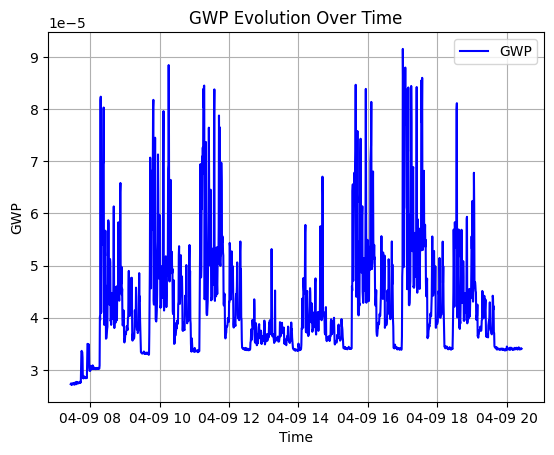

In [13]:
plt.plot(used_kvm["Time"], used_kvm["GWP"], label="GWP", color="blue")
plt.xlabel("Time")
plt.ylabel("GWP")
plt.title("GWP Evolution Over Time")
plt.legend()
plt.grid(True)
plt.show()

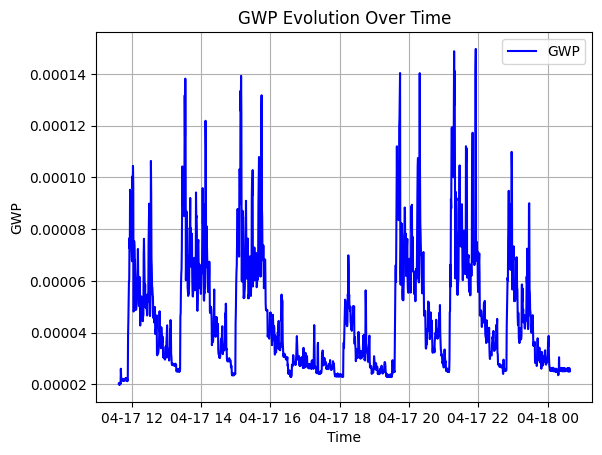

In [14]:
plt.plot(used_k8s["Time"], used_k8s["GWP"], label="GWP", color="blue")
plt.xlabel("Time")
plt.ylabel("GWP")
plt.title("GWP Evolution Over Time")
plt.legend()
plt.grid(True)
plt.show()

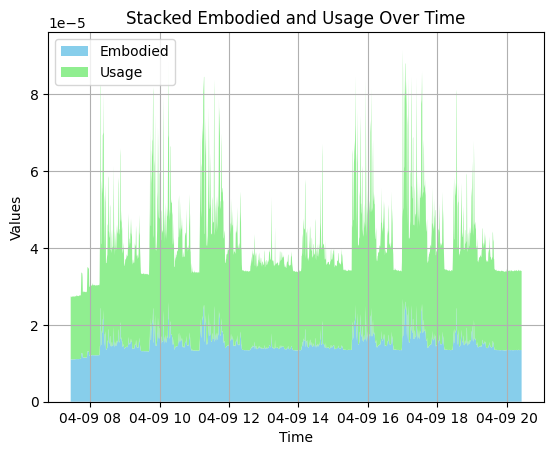

In [15]:
plt.stackplot(
    used_kvm["Time"],
    used_kvm["Embodied"],
    used_kvm["Usage"],
    labels=["Embodied", "Usage"],
    colors=["skyblue", "lightgreen"],
)

# Add labels, title, and legend
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Stacked Embodied and Usage Over Time")
plt.legend(loc="upper left")
plt.grid(True)

# Show the plot
plt.show()

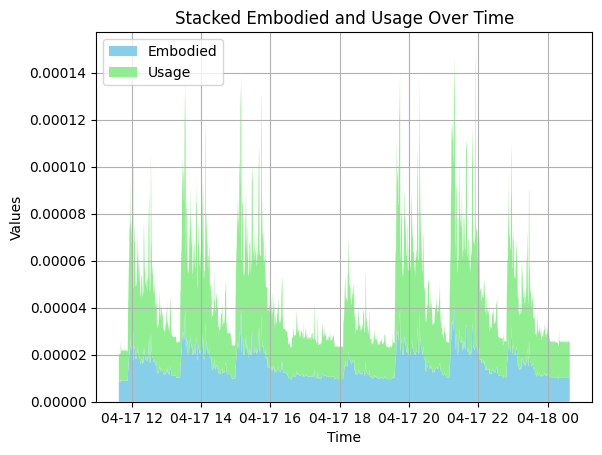

In [16]:
plt.stackplot(
    used_k8s["Time"],
    used_k8s["Embodied"],
    used_k8s["Usage"],
    labels=["Embodied", "Usage"],
    colors=["skyblue", "lightgreen"],
)

# Add labels, title, and legend
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Stacked Embodied and Usage Over Time")
plt.legend(loc="upper left")
plt.grid(True)

# Show the plot
plt.show()

<Axes: xlabel='Time'>

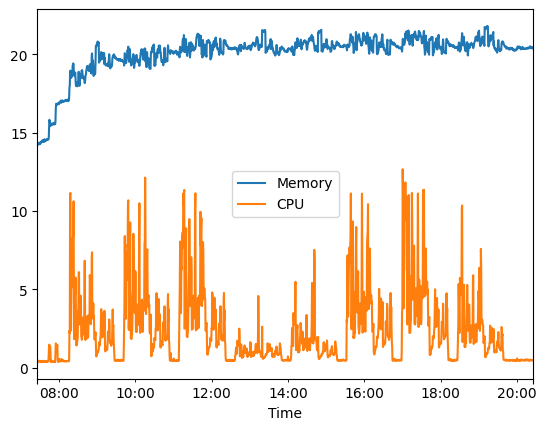

In [17]:
used_kvm[["Time", "Memory", "CPU"]].set_index("Time").plot()

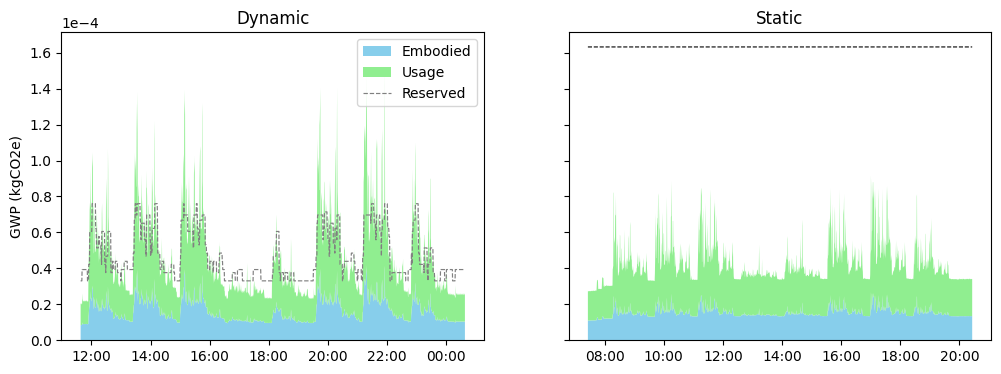

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=False, sharey=True)

axes[0].stackplot(
    used_k8s["Time"],
    used_k8s["Embodied"],
    used_k8s["Usage"],
    labels=["Embodied", "Usage"],
    colors=["skyblue", "lightgreen"],
)

axes[0].plot(
    used_k8s["Time"],
    reserved_k8s["GWP"],
    "--",
    color="grey",
    label="Reserved",
    linewidth=0.85,
)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
# axes[0].grid()
axes[0].set_ylabel("GWP (kgCO2e)")
axes[0].legend()
axes[0].set_title("Dynamic")

axes[1].stackplot(
    used_kvm["Time"],
    used_kvm["Embodied"],
    used_kvm["Usage"],
    labels=["Embodied", "Usage"],
    colors=["skyblue", "lightgreen"],
)
axes[1].plot(
    used_kvm["Time"],
    reserved_kvm["GWP"],
    "--",
    color="black",
    label="Reserved",
    linewidth=0.8,
)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# axes[1].grid()
axes[1].set_title("Static")
# axes[1].set_yticks([])

fig.set_size_inches((12, 4))
# Add labels, title, and legend
# plt.xlabel("Time")
# plt.title("Stacked Embodied and Usage Over Time")
# plt.legend(loc="upper left")
# plt.grid(True)

# Show the plot
plt.gcf().savefig("figures/wasted_resources/wasted_carbon.pdf", bbox_inches="tight")